categorical columns: Index(['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query',
       'dns_rejected', 'http_uri'],
      dtype='object')


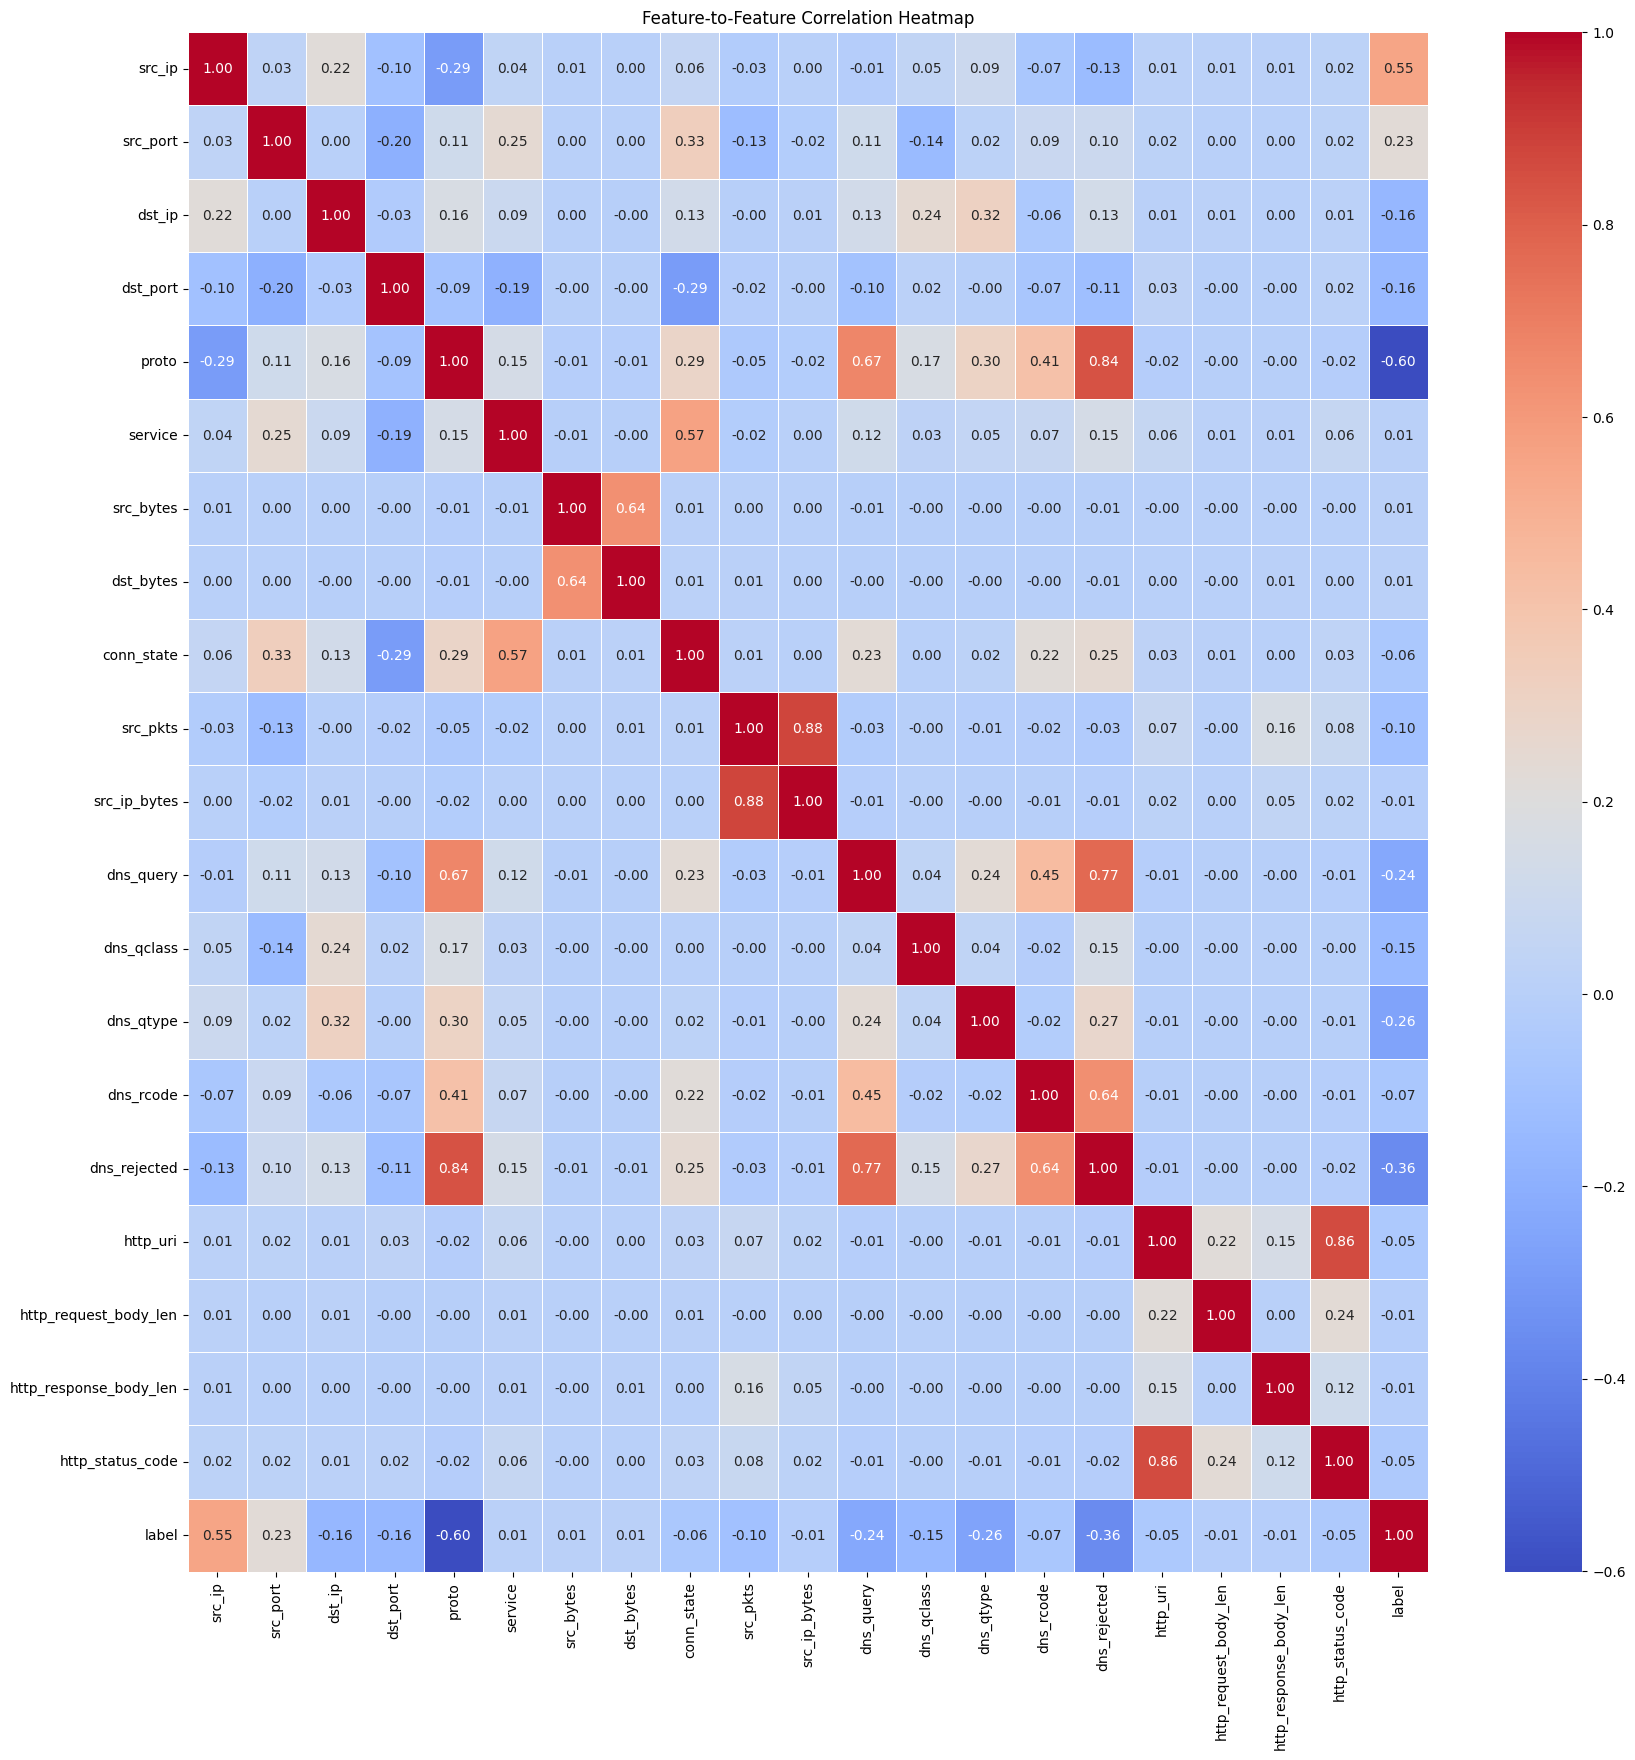

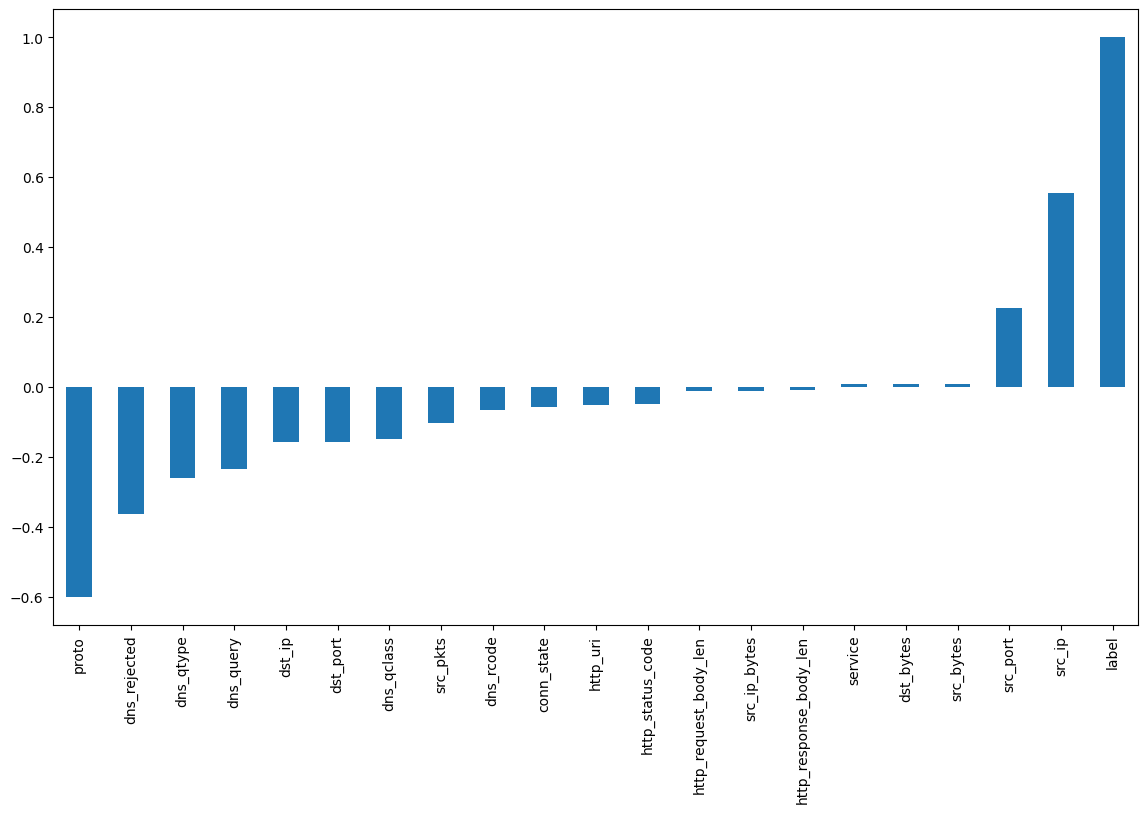

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('train_test_network.csv')
data = pd.DataFrame(data)

columns_to_drop = ['type', 'dst_ip_bytes', 'missed_bytes', 'duration', 'dst_pkts', 
                   'dns_RA', 'dns_AA', 'dns_RD', 'ssl_subject', 'ssl_issuer', 'ssl_version',
                   'ssl_cipher', 'ssl_resumed', 'ssl_established', 'http_trans_depth', 'http_method',
                   'http_version', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types',
                   'weird_name', 'weird_addl', 'weird_notice']
data_cleaned = data.drop(columns=columns_to_drop, axis=1)
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
print(f"categorical columns: {categorical_columns}")

# Apply LabelEncoder to categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))
    label_encoders[col] = le

correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature-to-Feature Correlation Heatmap')
plt.show()

correlations = data_cleaned.corr()['label'].sort_values()
plt.figure(figsize=(14, 8))
correlations.plot(kind='bar')
plt.show()


In [8]:
# Check class distribution
print(data_cleaned['label'].value_counts(normalize=True))

label
1    0.763081
0    0.236919
Name: proportion, dtype: float64


As we can see the class distribution is about 76% to 24%, indicating moderate class imbalance. Using SMOTE in this case could be beneficial.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def calculate_metrics(y_test, y_pred, model_name, smote_applied, results):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append((model_name, "With SMOTE" if smote_applied else "Without SMOTE", accuracy, precision, f1))
    print(f"{model_name} ({'With SMOTE' if smote_applied else 'Without SMOTE'}): "
          f"Accuracy = {accuracy:.8f}, Precision = {precision:.8f}, F1-Score = {f1:.8f}") # print with 8 digit precision

RANDOM_STATE = 42
LR_MAX_ITER = 300
MLP_MAX_ITER = 500
PR_MAX_ITER = 300
TEST_SIZE = 0.3

X = data_cleaned.drop("label", axis=1) # features
y = data_cleaned["label"] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE) # split into 0.7 data, 0.3 test data ratio

results = []
models = [ # models to be used
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("KNN", KNeighborsClassifier()),
    ("MLP Classifier", MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=MLP_MAX_ITER)),
    ("Perceptron", Perceptron(max_iter=PR_MAX_ITER))
]
for i in range(2): # train models without and then with SMOTE applied
    if (i == 1):
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("======================== AFTER APPLYING SMOTE ========================")
    for name, model in models:
        model.fit(X_train, y_train) # train the model
        y_pred = model.predict(X_test) # predictions

        calculate_metrics(y_test, y_pred, name, i, results)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
models_scaling_needed = [ # models that need scaling, StandardScaler in this case
    ("Logistic Regression", LogisticRegression(max_iter=LR_MAX_ITER))
]
print("\n")
for i in range(2):
    if (i == 1):
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_scaled, y_train_scaled = smote.fit_resample(X_train_scaled, y_train)
        print("======================== AFTER APPLYING SMOTE ========================")
    for name, model in models_scaling_needed:
        model.fit(X_train_scaled, y_train) # train the model
        y_pred = model.predict(X_test_scaled) # predictions
        
        calculate_metrics(y_test, y_pred, name, i, results)

Random Forest (Without SMOTE): Accuracy = 0.99998421, Precision = 0.99998421, F1-Score = 0.99998421
Decision Tree (Without SMOTE): Accuracy = 0.99993682, Precision = 0.99993684, F1-Score = 0.99993682
KNN (Without SMOTE): Accuracy = 0.98581650, Precision = 0.98578065, F1-Score = 0.98576370
MLP Classifier (Without SMOTE): Accuracy = 0.92935100, Precision = 0.93132334, F1-Score = 0.93007740
Perceptron (Without SMOTE): Accuracy = 0.87778181, Precision = 0.87521241, F1-Score = 0.86965915
======================== AFTER APPLYING SMOTE ========================
Random Forest (With SMOTE): Accuracy = 0.99998421, Precision = 0.99998421, F1-Score = 0.99998421
Decision Tree (With SMOTE): Accuracy = 0.99985785, Precision = 0.99985793, F1-Score = 0.99985786
KNN (With SMOTE): Accuracy = 0.98869111, Precision = 0.98872592, F1-Score = 0.98870474
MLP Classifier (With SMOTE): Accuracy = 0.97878793, Precision = 0.97886236, F1-Score = 0.97881949
Perceptron (With SMOTE): Accuracy = 0.35389257, Precision = 0.